# Mel spectrogram for ML project

In [9]:
%matplotlib widget
import IPython.display
from ipywidgets import interact, interactive, fixed

# Packages we're using
import numpy as np
import matplotlib.pyplot as plt
import librosa

In [10]:
## Test signal
Fe = 16000
T = 2
t = np.linspace( 0, T, T*Fe) # time vector

f0 = 200
f1 = 250
sig = np.sin( 2 * np.pi * f0 * t) + 0.5 * np.sin(2 * np.pi * f1 * t) # Signal of interest, sum of two sines


In [11]:
## Implementation of the STFT

def get_stft(sig, window = np.hanning(2**11), Nfft = 2**11, R = 2**9, plot = True, Fe = None):
    '''
    Computes the stft of signal x using numpy's fft implementation. 
    Inputs : 
    - sig : input signal,
    - window : window applied to the signal's frames,
    - Nfft : order of the TFD,
    - R : hop size
    Output : out, stft matrix of the signal (array, Nfft x Nt Nt being the number of frames)
    '''
    if plot == True and Fe == None:
        Fe = 16000
    N = len(sig)
    Nfreq = int(Nfft/2)+1
    Nw = len(window)
    Nt = np.int((N-Nw) / R)
    out = np.empty( (Nfreq, Nt))
    for u in range(Nt): # for each frame
        ind_start = int(u * R) # compute the frame's starting index
        ind_end = int(ind_start + Nw) # compute the frame's ending index
        sig_frame = sig[ind_start:ind_end] * window
        spectrum_frame = np.fft.fft(sig_frame,Nfft)
        out[:,u] = spectrum_frame[:Nfreq]
    if plot:
        plt.figure()
        plt.imshow(20*np.log10(np.abs(out)), aspect = 'auto', interpolation = 'none', extent=[0, Nt * R / Fe + Nw / 2, 0, Fe/2], origin = 'lower')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.title('Spectrogram')
    return out

C:\Users\mhart\anaconda\lib\site-packages\xpython_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part


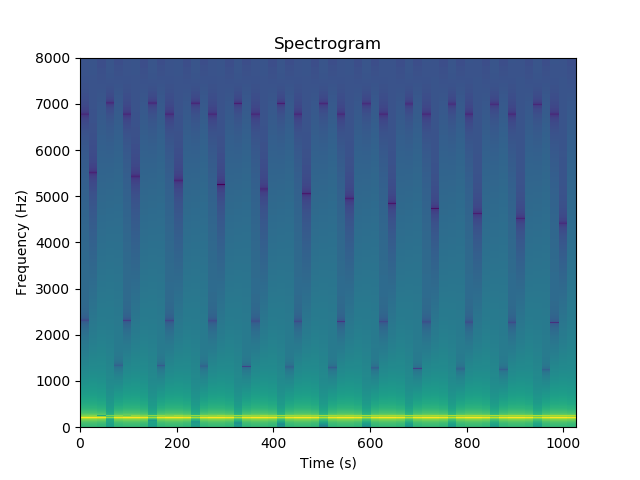

In [12]:
Nfft = 2**11
Nw = 2**11
window = np.hanning(Nw)
R = Nw/4

STFT = get_stft(sig, window, Nfft, R)

In [13]:
## Synthesis of the mel filterbank

def get_mel_filterbank(Fe = 16000, Nfft = 2**11, Nfilt = 2**11, plot = True):
    '''
    Compute the mel filters used to convert the spectrogram to a mel spectrogram.
    Inputs : 
    - Fe : sampling frequency (Hz),
    - Nfft : order of the FFT used to compute the spectrograms
    - Nfilt : number of mel filters to compute
    Output : mel_transfer_matrix, array whose columns are the mel filters (Nfft/2+1 x Nfilt)
    '''
    Nfreq = int(Nfft/2) + 1
    freq_vect_hz = np.linspace(0, Fe/2, int(Nfft/2) + 1)
    freq_vect_mel = 2595 * np.log10( 1 + freq_vect_hz / 700)
    mel_freq_max = freq_vect_mel[-1]
    filter_points_mel = np.linspace(0, mel_freq_max, Nfilt + 2)
    filter_points_hz = 700 * ( 10 ** (filter_points_mel / 2595) - 1)
    mel_transfer_matrix = np.zeros((Nfreq, Nfilt))
    for ind_filter in range(Nfilt):
        mel_freq_start = filter_points_hz[ind_filter]
        mel_freq_center = filter_points_hz[ind_filter + 1]
        mel_freq_end = filter_points_hz[ind_filter + 2]
        bool_first_part = (freq_vect_hz > mel_freq_start) & (freq_vect_hz < mel_freq_center)
        bool_second_part = (freq_vect_hz > mel_freq_center) & (freq_vect_hz < mel_freq_end)
        mel_transfer_matrix[bool_first_part, ind_filter] =  (freq_vect_hz[bool_first_part] - mel_freq_start)  / (mel_freq_center - mel_freq_start)
        mel_transfer_matrix[bool_second_part, ind_filter] =  (mel_freq_end - freq_vect_hz[bool_second_part])  / (mel_freq_end - mel_freq_center)
    if plot == True:
        plt.figure()
        plt.plot(freq_vect_hz, mel_transfer_matrix)
        plt.xlabel(r'Frequency (Hz)')
        plt.ylabel(r'Amplitude')
        plt.grid()
        plt.title(r'Mel filterbank')
    return freq_vect_mel, mel_transfer_matrix

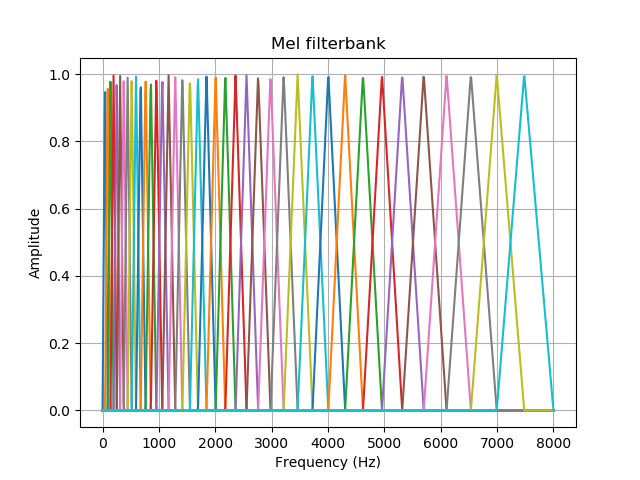

In [14]:
## Get the mel filterbank (example)

freq_vect_mel, mel_transfer_matrix = get_mel_filterbank(Nfilt = 40)

Problème: pour certains mel-filtres (surtout à basse fréquence), on ne tombe pas exactement sur les fréquences centrales. On n'arrive donc pas exactement à 1 pour ces filtres-ci, et on aura moins d'énergie que théoriquement une fois le signal filtré. C'est pire pour un nombre de filtres plus grand (cf. plus bas).

C:\Users\mhart\anaconda\lib\site-packages\xpython_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5,1,'mel-spectrogram')

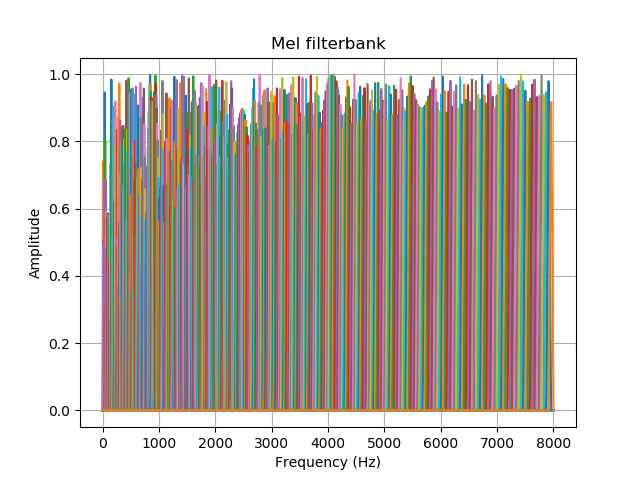

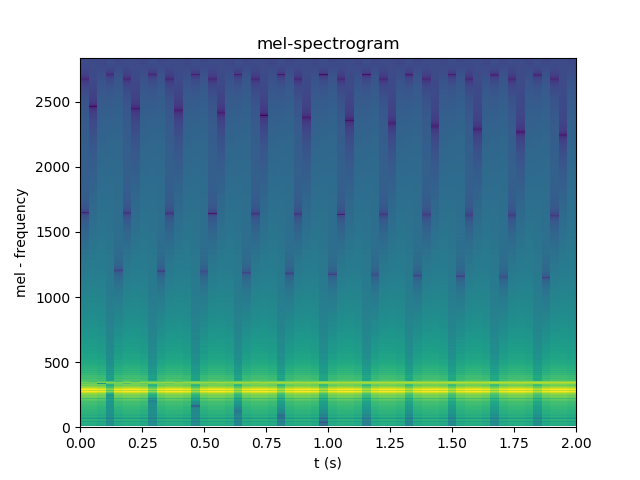

In [15]:
## Convert the original spectrogram to a mel-spectrogram

freq_vect_mel, mel_transfer_matrix = get_mel_filterbank(Nfilt = 2**9)

mel_spectrogram = np.matmul(mel_transfer_matrix.transpose(),STFT)

plt.figure()
plt.imshow(20*np.log10(np.abs(mel_spectrogram)), aspect = 'auto', interpolation = 'none', extent=[0, T, 0, freq_vect_mel[-1]], origin = 'lower')
plt.xlabel('t (s)')
plt.ylabel('mel - frequency')
plt.title('mel-spectrogram')

Comme indiqué plus haut, les amplitudes des filtres de mel à basse fréquence sont souvent bien inférieurs à $1$. Je pense que c'est la raison pour laquelle on observe un trou dans le spectre à très basse fréquence (cf. plus bas où on a encore plus de trous si on utilise plus de filtres mel).

C:\Users\mhart\anaconda\lib\site-packages\xpython_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  return args.f


Text(0.5,1,'mel-spectrogram')

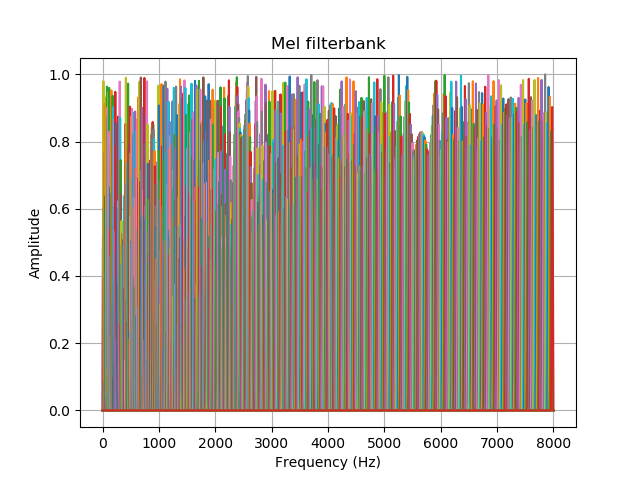

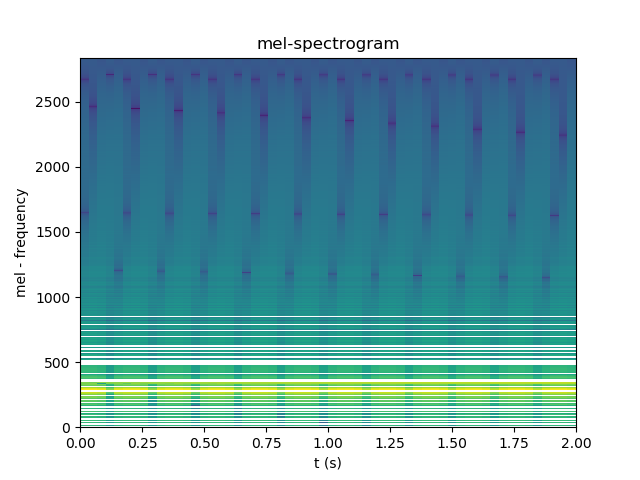

In [16]:
## Convert the original spectrogram to a mel-spectrogram
freq_vect_mel, mel_transfer_matrix = get_mel_filterbank(Nfilt = 2**10)

mel_spectrogram = np.matmul(mel_transfer_matrix.transpose(),STFT)

plt.figure()
plt.imshow(20*np.log10(np.abs(mel_spectrogram)), aspect = 'auto', interpolation = 'none', extent=[0, T, 0, freq_vect_mel[-1]], origin = 'lower')
plt.xlabel('t (s)')
plt.ylabel('mel - frequency')
plt.title('mel-spectrogram')

# Griffin-Lim reconstruction

Application of the LSEE-MSTFTM algorithm, as described in "Signal estimation from modified short-time fourier transform" (1984), by Griffin and Lim,
    
The algorithm is meant to recover a signal from the magnitude of a (modified) STFT, by minimizing the MSE between the magnitude of the estimated signal's actual STFT and the magnitude of the modified STFT.

## First from a normal spectrogram

The following function finds the signal whose STFT is closest to a modified STFT (which is not necessarily a STFT) in a MSE sense (see equation 6 of the article). 

In [ ]:
def get_closest_stft(X, window = np.hanning(2**11), Nfft = 2**11, R = 2**9, plot = True, Fe = None):
    '''
    This function computes the signal x whose STFT is closest to the array X (the modified STFT), according to equation 6 in the article.
    This procedure is close, but not exactly equivalent, to the OLA method.
    INPUTS :
    - X : the modified STFT,
    - window: assumed window for the STFT,
    - Nfft : assumed number of FFT points for the STFT,
    - R : assumed hop size for the STFT,
    - plot : boolean, if True the STFT of the output signal is plotted,
    - Fe : sampling frequency
    OUTPUT : 
    - x : the estimated signal
    '''
    nb_frames = X.shape[0]
    Nw = len(window)
    signal_length = int(nb_fr) # TODO : FIX THIS, might be wrong
    x = np.empty(signal_length)
    for ind_frame,ind_time in enumerate(range(signal_length-Nw,R)):
        x[ind_time:ind_time+Nw] += window*np.real(np.fft.ifft(X[ind_frame])) # TODO : maybe we need the negative frequencies as well here, be careful
    # TODO : the plot code
    return x

The following code is an implementation of the algorithm, described figure 1 of the article.

In [22]:
STFTM = np.abs(STFT) # The ground truth, STFT magnitude of the signal

nb_frames = STFT_mag.shape[0]
signal_length = int(nb_frames*R + Nw) # TODO : FIX THIS, might be wrong

N_iterations = 10# number of iterations 
loss = np.empty(N_iterations) # to show the evolution of the loss (MSE) over the iterations

#TODO : fix the initial signal's length
x_recovered = np.random.rand(T*Fe) # Initial guess for the reconstructed signal, a Gaussian noise in the original article
for ind_iteration in range(N_iterations):
    STFT_hat = get_stft(x_recovered) # STFT of the recovered signal
    STFT_hat_magnitude = np.abs(STFT_hat)
    STFT_hat_angle = np.angle(STFT_hat)
    STFT_estimation = STFTM*np.exp(1j*STFT_hat_angle) #
    x_recovered = get_closest_stft(STFT_estimation) # Update the recovered signal
    loss[ind_iteration] = np.norm(STFT_hat_magnitude-STFTM)

32000
526848
